In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

from defPrincipal import *

%matplotlib inline

In [2]:
from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=24)
client = Client(cluster)
client

/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: inproc://134.246.146.72/5485/1 Dashboard: http://134.246.146.72/5485/1:38387/status,Cluster Workers: 1 Cores: 24 Memory: 67.17 GB


In [3]:
def _adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='m', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )
        # Create xgcm grid
        coords={'xi':{'center':'x_rho', 'inner':'x_u'}, 
                'eta':{'center':'y_rho', 'inner':'y_v'}, 
                's':{'center':'s_rho', 'outer':'s_w'}}
        ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords)
        
        return ds

In [4]:
# On récupère la liste des fichiers à ouvrir via le fichier liste 
#path = "/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/"
path = "/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/"
filenames = path + pd.read_csv('../liste.122014',header=None)
filenames = filenames.values.flatten().tolist()
filenames

['/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-12-03-2014-12-07.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-12-08-2014-12-12.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-12-13-2014-12-17.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-12-18-2014-12-22.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-12-23-2014-12-27.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-12-28-2015-01-01.nc']

In [5]:
#ds = xr.open_dataset(filenames[0],chunks={'time_counter':1, 's_rho':1, 's_w' :1})
#ds = xr.open_mfdataset(filenames,chunks={'time_counter':1, 's_rho':1, 's_w':1})
datasets = []
for f in filenames:
    ds = xr.open_dataset(f, chunks={'time_counter': 1, 's_rho': 1},
                         drop_variables=['time','ubar', 'vbar', 'sustr', 'svstr','bvf','temp','salt'])
    datasets.append(ds)
ds = xr.concat(datasets, dim='time_counter', coords='minimal', compat='override')
# ds = ds.mean(dim="time_counter")
ds

<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, s_rho: 50, s_w: 51, time_counter: 58, x_rho: 1502, x_u: 1501, x_v: 1502, x_w: 1502, y_rho: 2002, y_u: 2002, y_v: 2001, y_w: 2002)
Coordinates:
    nav_lon_u            (y_u, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    nav_lon_v            (y_v, x_v) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    nav_lat_v            (y_v, x_v) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    nav_lon_rho          (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lat_rho          (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lat_u            (y_u, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
  * s_w                  (s_w) float32 -1.0 -0.98 -0.96 ... -0.04 -0.02 0.0
  * s_rho                (s_rho) float32 -0.99 -0.97 -0.95 ... -0.05 -0.03 -0.01
    time_instant         (time_counter) datetime64[ns] d

In [6]:
# On ajoute dans le dataset les paramètres de grille qui sont dans le 1ier fichier
gridname = path+'GIGATL6_12h_inst_2004-01-15-2004-01-19.nc'
gd = xr.open_dataset(gridname, chunks={'s_rho': 1, 's_w' :1})
ds['hc'] = gd.hc
ds['h'] = gd.h
ds['Vtransform'] = gd.Vtransform
ds['sc_r'] = gd.sc_r
ds['sc_w'] = gd.sc_w
ds['Cs_r'] = gd.Cs_r
ds['Cs_w'] = gd.Cs_w
ds['angle'] = gd.angle
ds['mask_rho'] = gd.mask_rho

In [7]:
# On modifie des dimensions et des coordonnées, on crée la grille xgcm
ds = _adjust_grid(ds)
grid = ds.attrs['xgcm-Grid']
L = ds.dims['x_rho']
M = ds.dims['y_rho']
N = ds.dims['s_rho']

In [8]:
u = ds.u.sel(s_rho=-0.91)
v = ds.v.sel(s_rho=-0.91)
[urot,vrot] = rotuv(ds, u=u, v=v)
vrot2=vrot.persist()
print(vrot2)

elaps is : 0.1633055810816586
elaps is : 18.27602573670447
<xarray.DataArray (time_counter: 58, y_rho: 2002, x_rho: 1502)>
dask.array<add, shape=(58, 2002, 1502), dtype=float32, chunksize=(1, 2000, 1500), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2014-12-03T12:00:00 ... 2015-01-01
    eta_rho       (y_rho, x_rho) float32 -53.601315 -53.618214 ... 65.42858
    xi_rho        (y_rho, x_rho) float32 -73.286835 -73.21415 ... 27.151964
Dimensions without coordinates: y_rho, x_rho


CPU times: user 2.97 s, sys: 593 ms, total: 3.56 s
Wall time: 1.9 s


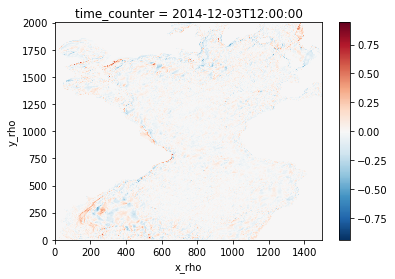

In [9]:
%%time
vrot2.isel(time_counter=0).plot()

In [10]:
cluster.close()

KeyboardInterrupt: 